# Homework #5 - Ravi Raghavan

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt

## Theoretical Calculations of Gradient and Hessian

$f(x) = - \sum_{i=1}^{m} \log{(1 - a_i^Tx)} - \sum_{i=1}^{n} \log{(1 - x_i^2)}$

$x \in \mathbb{R}^n$ and $dom f = \{ x | a_i^Tx < 1, i = 1, 2, ..., m, |x_i| < 1, i = 1, 2, ..., n\}$


This can also be expressed as 

$f(x) = - \sum_{i=1}^{m} \log{(1 - a_i^Tx)} - \sum_{i=1}^{n} \log{(1 - x_i)} - \sum_{i=1}^{n} \log{(1 + x_i)}$

$x \in \mathbb{R}^n$ and $dom f = \{ x | a_i^Tx < 1, i = 1, 2, ..., m, |x_i| < 1, i = 1, 2, ..., n\}$


$\frac{\partial{f}}{\partial{x_j}} = - (\sum_{i=1}^{m} (\frac{1}{1 - a_i^Tx}) (-a_{ij})) - \frac{1}{(1 - x_j^2)} (-2x_j)$

$\frac{\partial{f}}{\partial{x_j}} =  \sum_{i=1}^{m} (\frac{a_{ij}}{1 - a_i^Tx}) + \frac{2x_j}{(1 - x_j^2)}$


$\frac{\partial{f}}{\partial{x_k} \partial{x_j}}$: 

Case where $j = k$:

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} a_{ij} (\frac{-1}{(1 - a_i^Tx)^2}) (-a_{ik}) + \frac{2(1 - x_j^2) - 2x_j(-2x_j)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$


Case where $j \neq k$: 

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})$





## Programmatic Implementations of Descent Methods

In [2]:
#Function to Perform Gradient Descent
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def gradient_descent(f, gradient, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store step sizes
    step_sizes = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient        
        # print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}")
        
        #if we have satisfied our convergence criteria, break from loop
        if np.linalg.norm(grad) <= eta:
            break
        
        descent_direction = -1 * grad #our descent direction is the negative gradient
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store step size
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [3]:
#H: Hessian of function at a given point
#g: gradient of function at given point
#This function solves the system H @ x_nt = -g to calculate the newton direction
def solve_newton_system(H: np.ndarray, g: np.ndarray):
    L = np.linalg.cholesky(H) #compute Cholesky Decomposition of H
    n = L.shape[0]
    
    #forward substitution to solve Lw = b where b = -g
    w = np.zeros(shape = g.shape)
    b = -1 * g
    
    w[0, 0] = b[0, 0] / L[0, 0]
    for idx in range(1, n):
        w[idx, 0] = (b[idx, 0] - np.dot(L[idx, :idx].flatten(), w[:idx, 0].flatten())) / L[idx, idx]
    
    #backward substitution to solve L^T @ x_nt = w
    L_transpose = L.T
    x_nt = np.zeros(shape = g.shape)
    
    x_nt[n - 1, 0] = w[n - 1, 0] / L_transpose[n - 1, n - 1]
    for idx in range(n - 2, -1, -1):
        x_nt[idx, 0] = (w[idx, 0] - np.dot(L_transpose[idx, -1:idx:-1].flatten(), x_nt[-1:idx:-1, 0].flatten())) / L_transpose[idx, idx]
    
    #Calculate lambda^2
    lambda_squared = np.linalg.norm(w) ** 2
    
    ##Sanity Check
    closed_form = -1 * (np.linalg.inv(H) @ g)
    assert np.allclose(x_nt, closed_form)
    
    return x_nt, lambda_squared

In [4]:
#Function to Perform Newton's Method
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store step sizes
    step_sizes = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = hessian(A, x) #compute hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        # print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Norm of Hessian: {np.linalg.norm(H)}, Newton Parameter: {newton_parameter}")
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
        
        descent_direction = newton_direction #our descent direction is the newton direction
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store step size
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [5]:
#Function to Perform Newton's Method where the Hessian is reused every N iterations
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
#N: number of iterations after which Hessian is evaluated
def reuse_newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta, N):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store step sizes
    step_sizes = []
    
    #Store Hessians
    hessians = []
    H = hessian(A, x) #compute hessian
    hessians.append(H)
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        
        #Get Hessian
        if (iter > 0) and (iter % N == 0):
            H = hessian(A, x)
            hessians.append(H)
        else:
            H = hessians[-1]
        
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        # print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Norm of Hessian: {np.linalg.norm(H)}, Newton Parameter: {newton_parameter}")
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
        
        descent_direction = newton_direction #our descent direction is the newton direction
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store step size
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [6]:
#Function to Perform Newton's Method where the Hessian is approximated by its diagonal
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def diagonal_newton_descent(f, gradient, diagonal_hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    step_sizes = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = diagonal_hessian(A, x) #compute diagonal hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        # print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Norm of Hessian: {np.linalg.norm(H)}, Newton Parameter: {newton_parameter}")
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
        
        descent_direction = newton_direction #our descent direction is the newton direction
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store alpha
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [7]:
#A: Matrix such that each row of A is ai
#x: x
#This function, given A and x, check to see if x is within the domain of f
#returns True if x is in the domain of f 
#returns False is x is NOT in the domain of f
def domain_check(A: np.ndarray, x: np.ndarray):
    B = A @ x
    max_B = np.max(B)
    max_x = np.max(np.abs(x))
    return max_B < 1 and max_x < 1

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    B = A @ x
    
    log_comp_B = np.log(1 - B)
    log_plus_x = np.log(1 + x)
    log_minus_x = np.log(1 - x)
    
    return (-1 * np.sum(log_comp_B)) - np.sum(log_plus_x) - np.sum(log_minus_x)

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the gradient of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_gradient(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x    
    gradient_vector = (A.T @ (1 / (1 - B))) + (1 / (1 - x)) - (1 / (1 + x))    
    return gradient_vector   

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the Hessian of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    C = 1 / (1 - B)
    C_squared = C ** 2
    C_squared = C_squared.flatten()
    
    plus_x_squared = 1 / ((1 + x) ** 2)
    minus_x_squared = 1 / ((1 - x) ** 2)
    combined = plus_x_squared + minus_x_squared
    combined = combined.flatten()
    
    H = (A.T @ np.diag(C_squared) @ A) + np.diag(combined)    
    return H

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the Diagonal Approximation of Hessian of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_diagonal_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    C = 1 / (1 - B)
    C_squared = C ** 2
    
    A_transpose_squared = ((A.T) ** 2)
    D = A_transpose_squared @ C_squared
    D = D.flatten()
    
    plus_x_squared = 1 / ((1 + x) ** 2)
    minus_x_squared = 1 / ((1 - x) ** 2)
    combined = plus_x_squared + minus_x_squared
    combined = combined.flatten()
    
    H = np.diag(D) + np.diag(combined)    
    return H

#This function performs backtracking
#A: Matrix such that each row of A is ai
#x: x
#delta_x: search direction
#alpha: alpha parameter
#beta: beta parameter
def f_backtracking_algorithm(A: np.ndarray, x: np.ndarray, delta_x: np.ndarray, alpha, beta):
    t = 1
    
    #First we must multiply t by Beta until we get within the domain
    while not domain_check(A, x + (t * delta_x)):
        t = beta * t
    
    #Multiply t by beta until the backtracking stopping condition is met
    while (f(A, x + (t * delta_x))) > (f(A, x) + (alpha * t * (f_gradient(A, x).T @ delta_x))):
        t = beta * t
            
    return t 

## 9.30 (a): Gradient Descent Method with Backtracking Line Search

### Experiment #1: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.1$ 

In [8]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.1
eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [9]:
## Investigate Matrix A
max_A = np.max(A)
min_A = np.min(A)
print(f"Minimum Element in A: {min_A}")
print(f"Maximum Element in A: {max_A}")

Minimum Element in A: -4.4466322413592945
Maximum Element in A: 3.8016602149671153


In [10]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed0 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

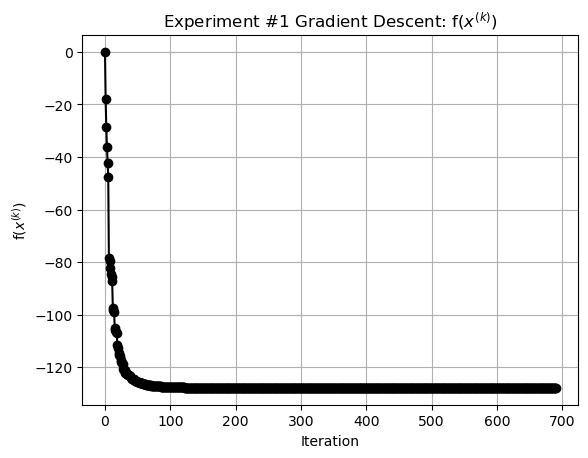

In [11]:
#Plot function values throughout gradient descent
fig1 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

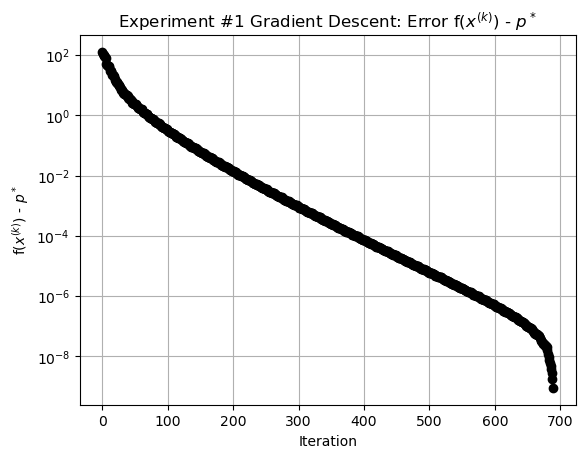

In [12]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

fig2 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

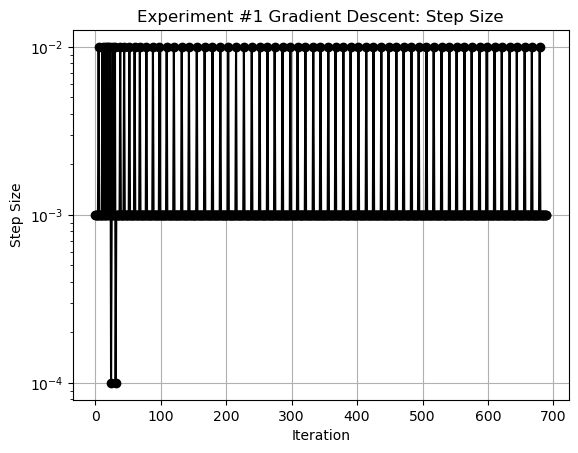

In [13]:
#Plot step sizes that were used during each iteration of gradient descent
fig3 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #1 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #2: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.5$ 

In [14]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [15]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

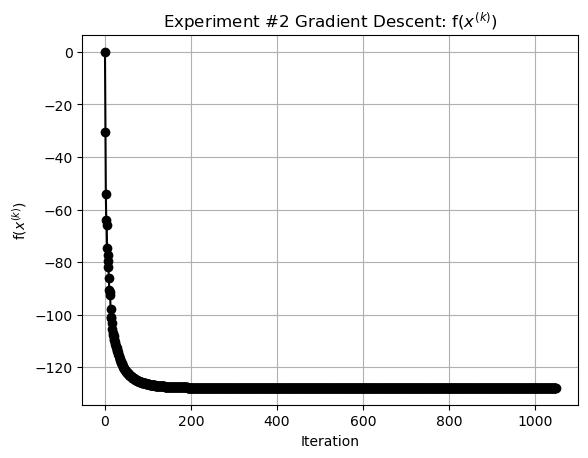

In [16]:
#Plot function values throughout gradient descent
fig4 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

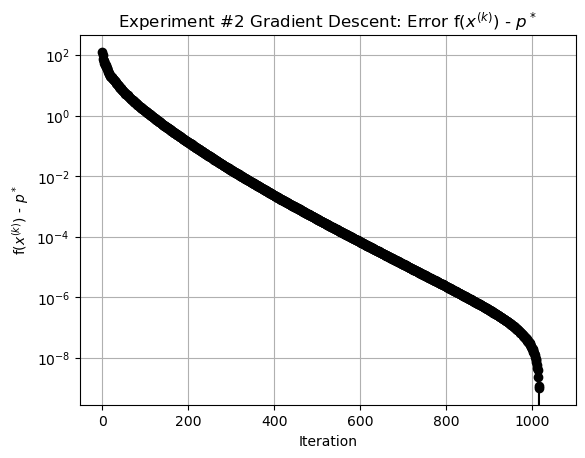

In [17]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
fig5 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

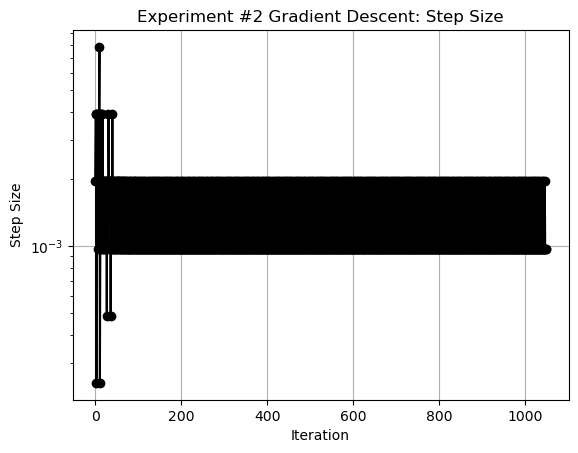

In [18]:
#Plot step sizes that were used during each iteration of gradient descent
fig6 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #2 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #3: n = 100, m = 200, $\alpha = 0.15$, $\beta = 0.1$ 

In [19]:
#Global Variables
n = 100
m = 200
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [20]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

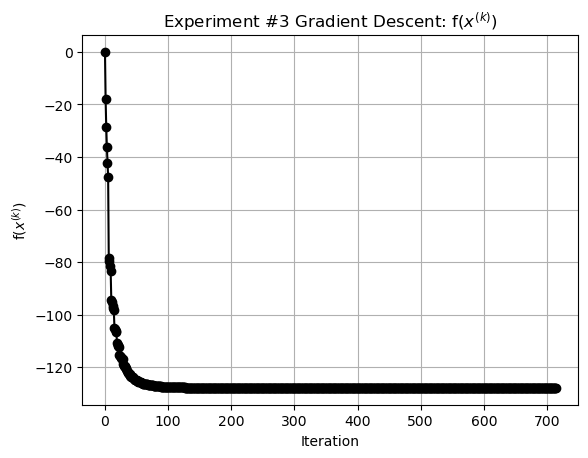

In [21]:
#Plot function values throughout gradient descent
fig7 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

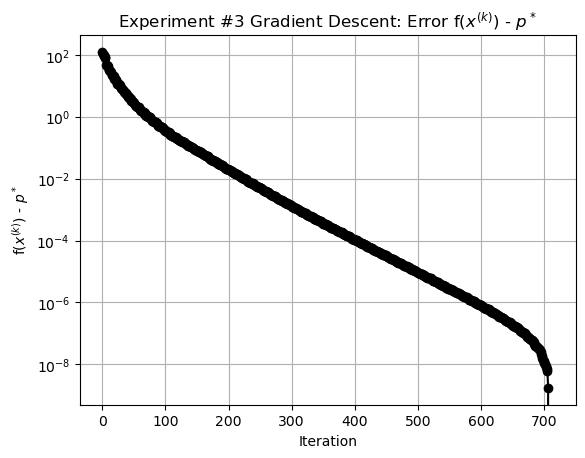

In [22]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
fig8 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

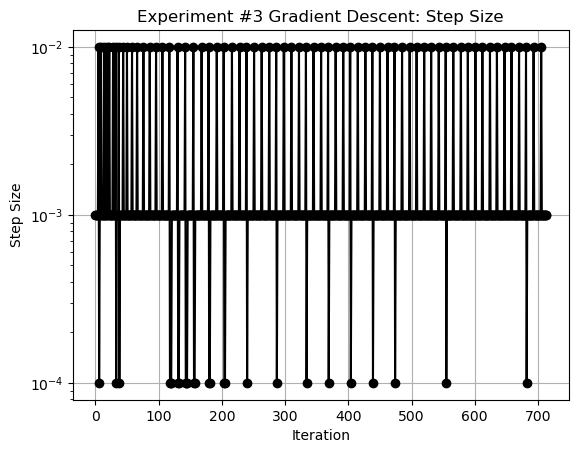

In [23]:
#Plot step sizes that were used during each iteration of gradient descent
fig9 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #3 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #4: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.1$ 

In [24]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [25]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed1 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

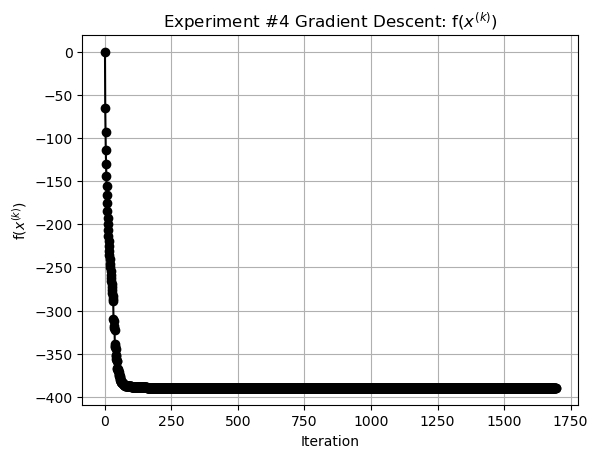

In [26]:
#Plot function values throughout gradient descent
fig10 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #4 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

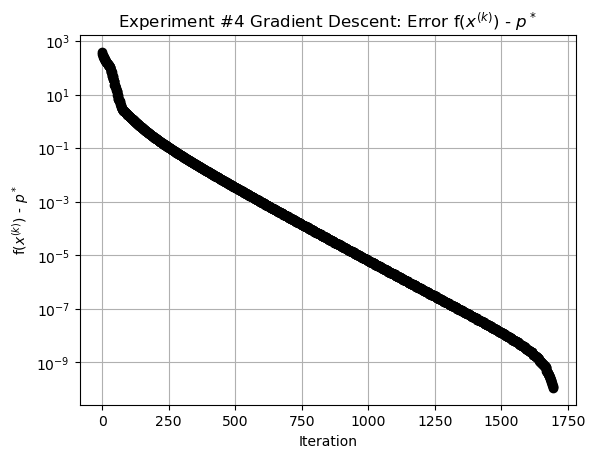

In [27]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]
fig11 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #4 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

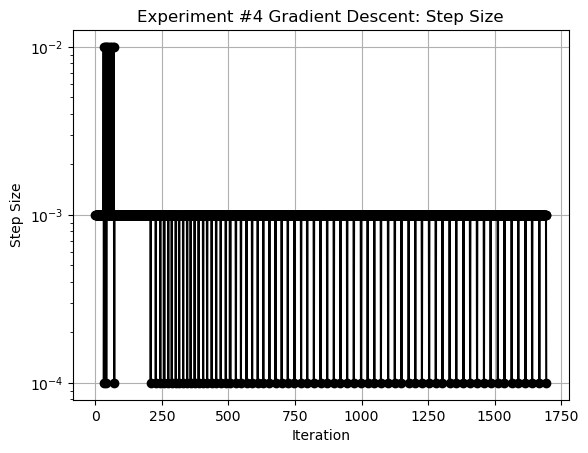

In [28]:
#Plot step sizes that were used during each iteration of gradient descent
fig12 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #4 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #5: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.5$ 

In [29]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [30]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

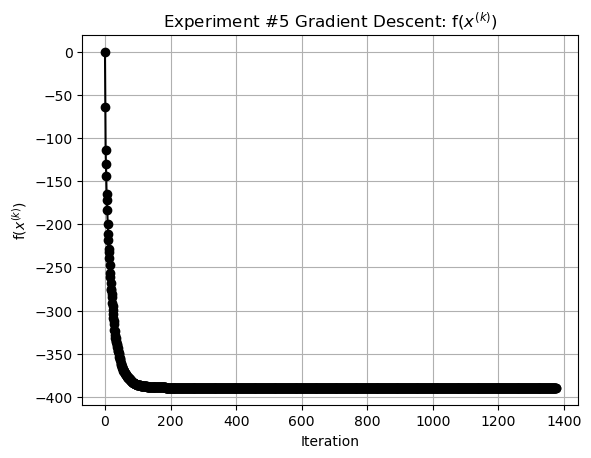

In [31]:
#Plot function values throughout gradient descent
fig13 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #5 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

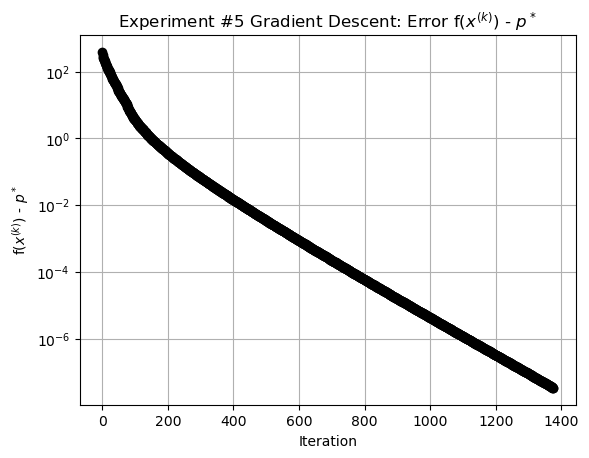

In [32]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
fig14 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #5 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

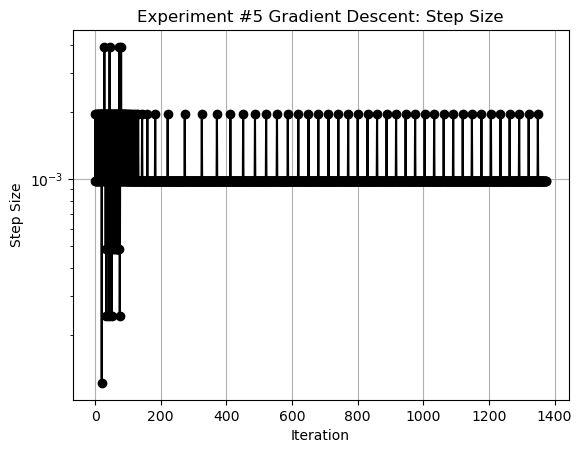

In [33]:
#Plot step sizes that were used during each iteration of gradient descent
fig15 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #5 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #6: n = 200, m = 400, $\alpha = 0.15$, $\beta = 0.1$ 

In [34]:
#Global Variables
n = 200
m = 400
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [35]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

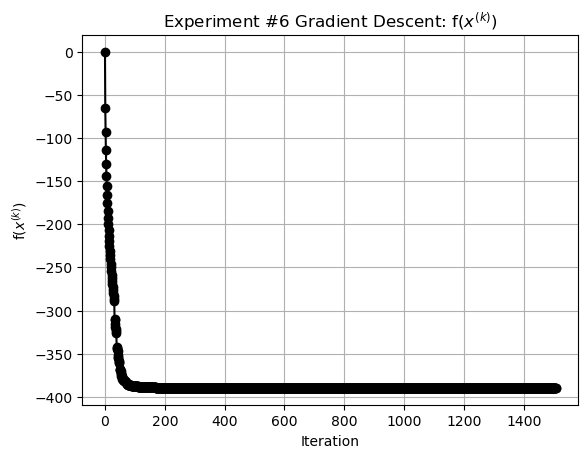

In [36]:
#Plot function values throughout gradient descent
fig16 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #6 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

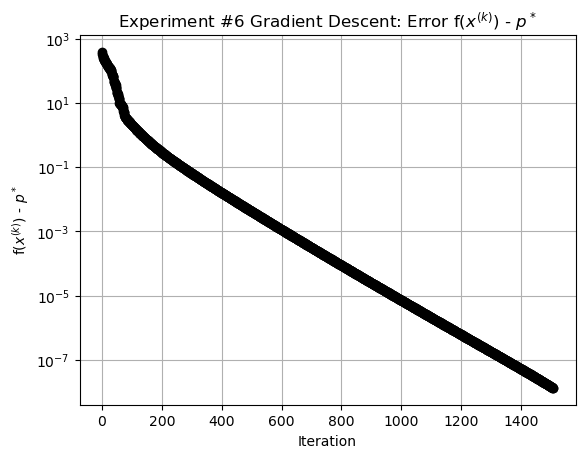

In [37]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
fig17 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #6 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

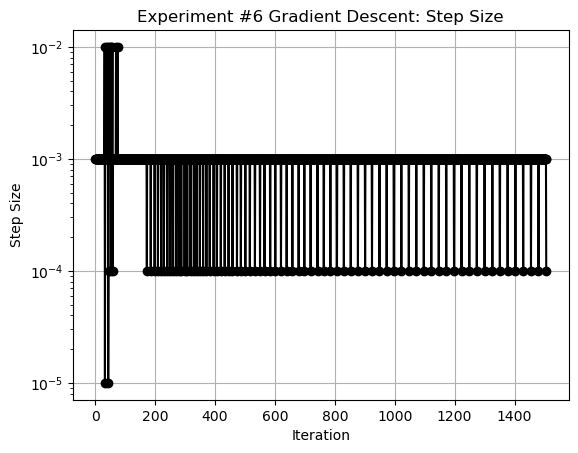

In [38]:
#Plot step sizes that were used during each iteration of gradient descent
fig18 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #6 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #7: n = 50, m = 100, $\alpha = 0.01$, $\beta = 0.1$ 

In [39]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [40]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed2 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

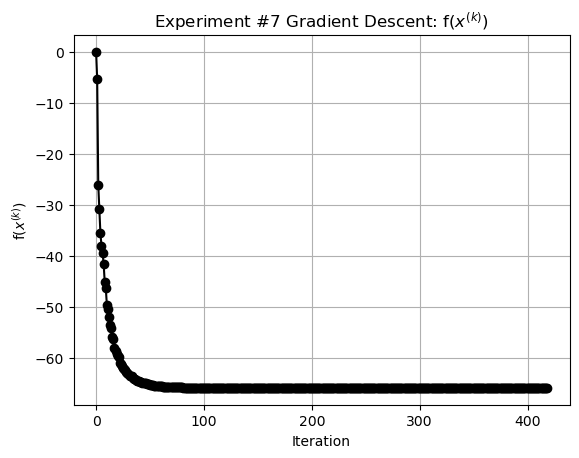

In [41]:
#Plot function values throughout gradient descent
fig19 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #7 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

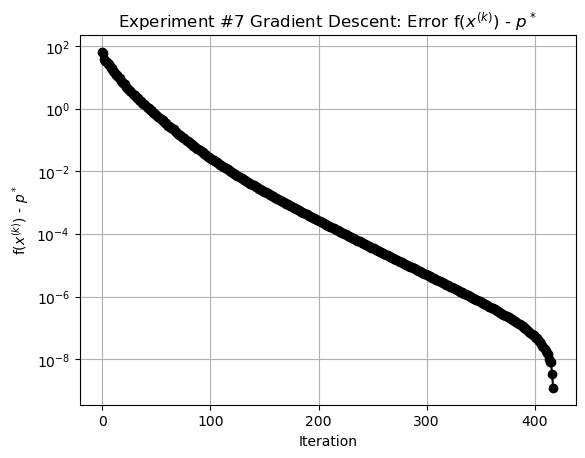

In [42]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]
fig20 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #7 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

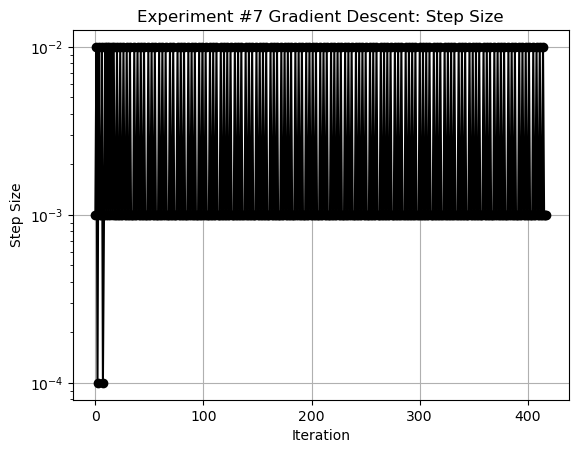

In [43]:
#Plot step sizes that were used during each iteration of gradient descent
fig21 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #7 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #8: n = 50, m = 100, $\alpha = 0.01$, $\beta = 0.5$ 

In [44]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [45]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

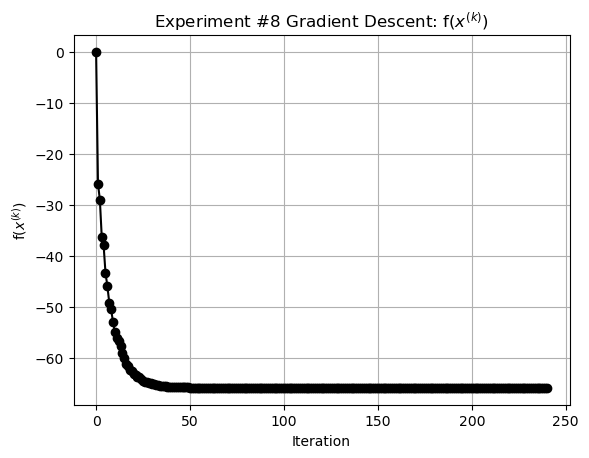

In [46]:
#Plot function values throughout gradient descent
fig22 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #8 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

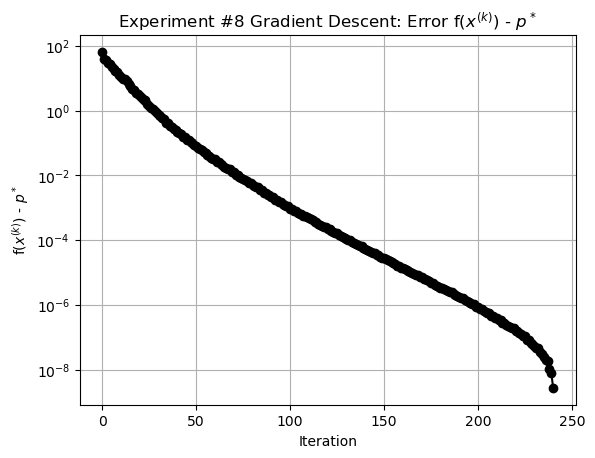

In [47]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
fig23 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #8 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

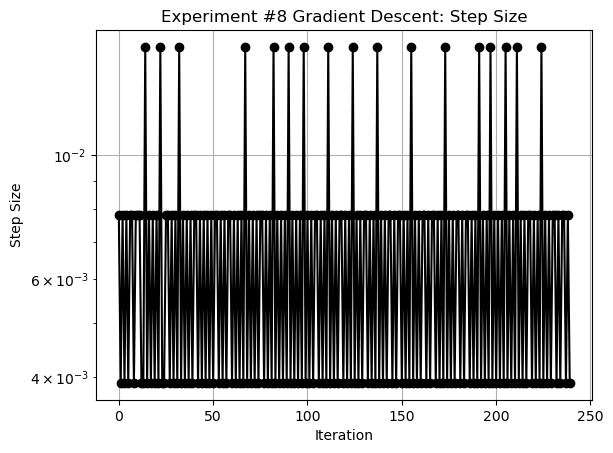

In [48]:
#Plot step sizes that were used during each iteration of gradient descent
fig24 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #8 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #9: n = 50, m = 100, $\alpha = 0.15$, $\beta = 0.1$ 

In [49]:
#Global Variables
n = 50
m = 100
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [50]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

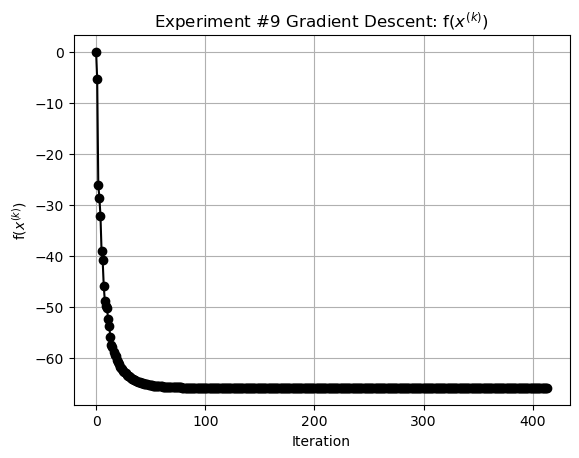

In [51]:
#Plot function values throughout gradient descent
fig25 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #9 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

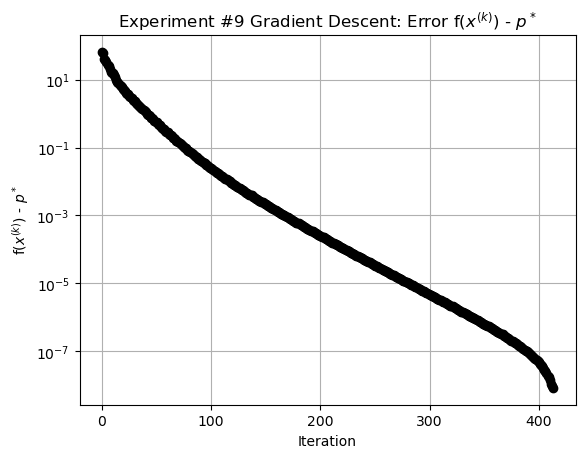

In [52]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
fig26 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #9 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

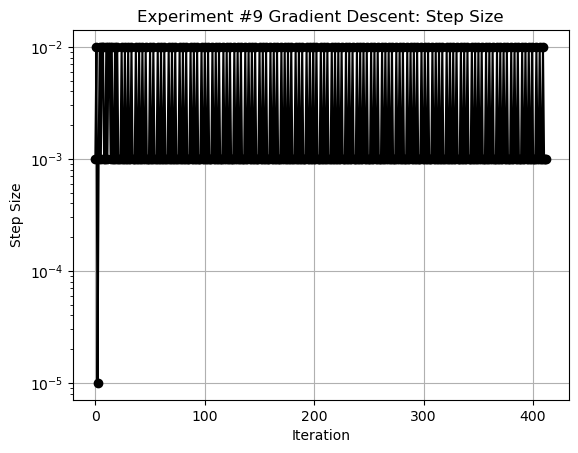

In [53]:
#Plot step sizes that were used during each iteration of gradient descent
fig27 = plt.figure()  # Create a new figure
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #9 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

Observations:
- Backtracking Parameters $\alpha$ and $\beta$ affect the performance of Gradient Descent Algorithm
- Performance does not really scale well with problem size

## 9.30 (b)

### Experiment #1: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.1$ 

In [54]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.1
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [55]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

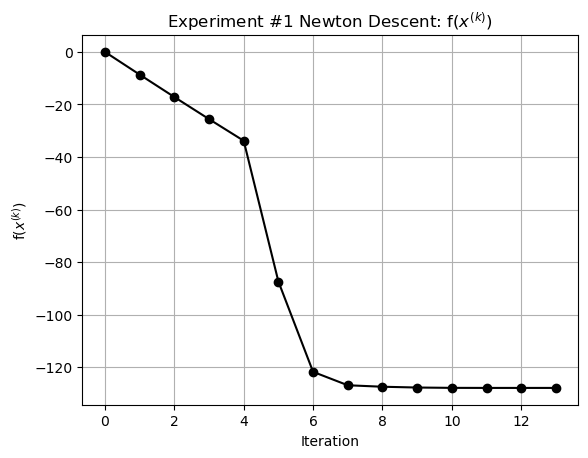

In [56]:
#Plot function values throughout Newton's Method
fig28 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

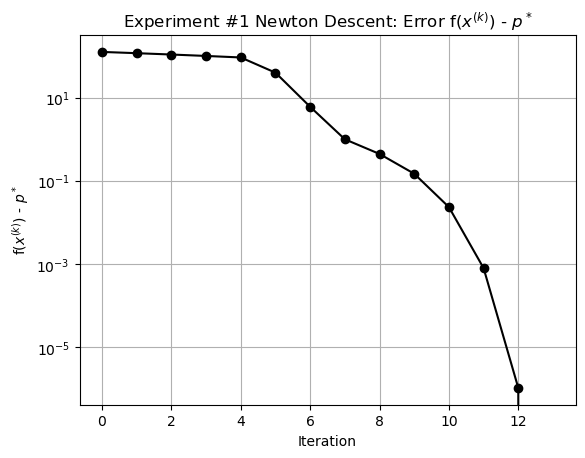

In [57]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
fig29 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [58]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

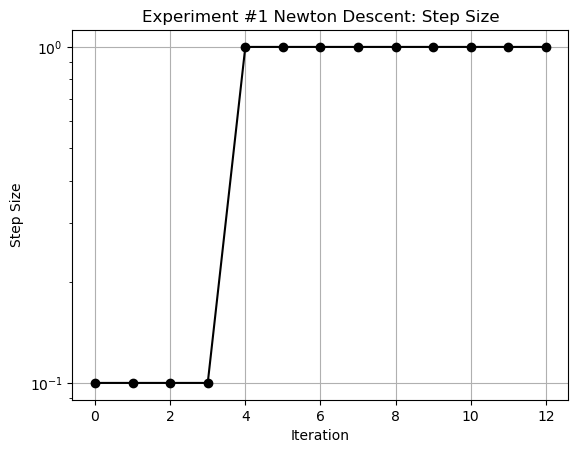

In [59]:
#Plot step sizes during Newton's Method
fig30 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #2: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.5$ 

In [60]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [61]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

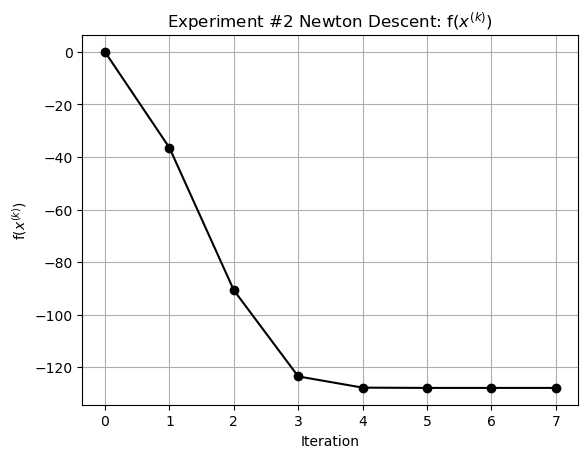

In [62]:
#Plot function values throughout Newton's Method
fig31 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

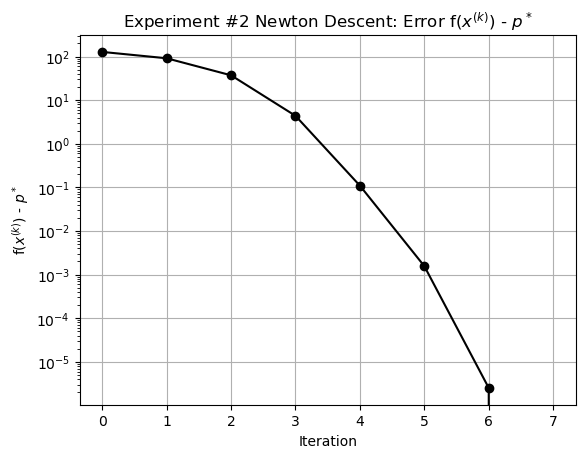

In [63]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
fig32 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [64]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([0.5, 1. , 1. , 1. , 1. , 1. , 1. ])

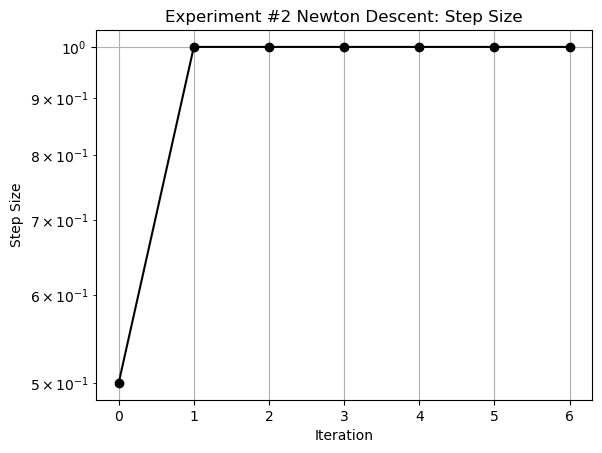

In [65]:
#Plot step sizes during Newton's Method
fig33 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #3: n = 100, m = 200, $\alpha = 0.15$, $\beta = 0.1$ 

In [66]:
#Global Variables
n = 100
m = 200
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [67]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

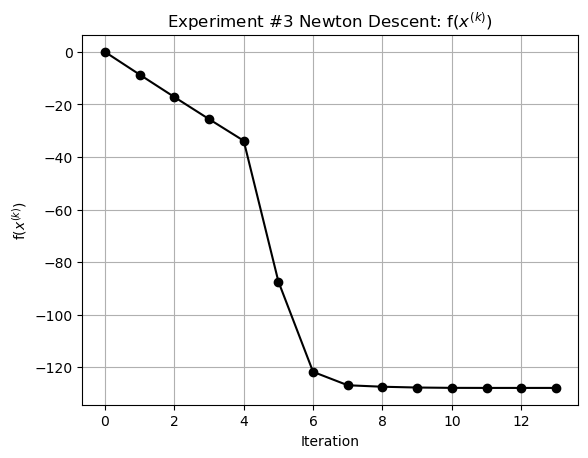

In [68]:
#Plot function values throughout Newton's Method
fig34 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

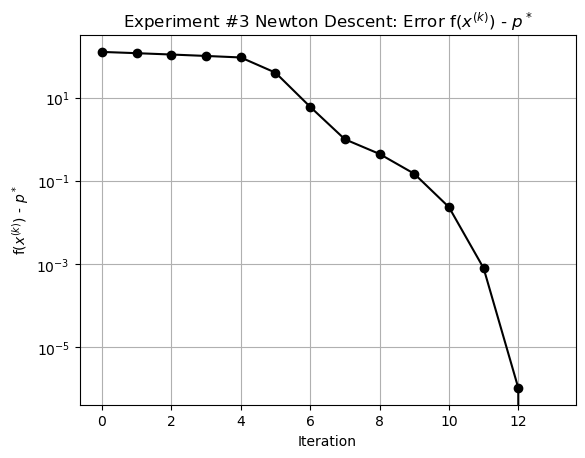

In [69]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
fig35 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [70]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

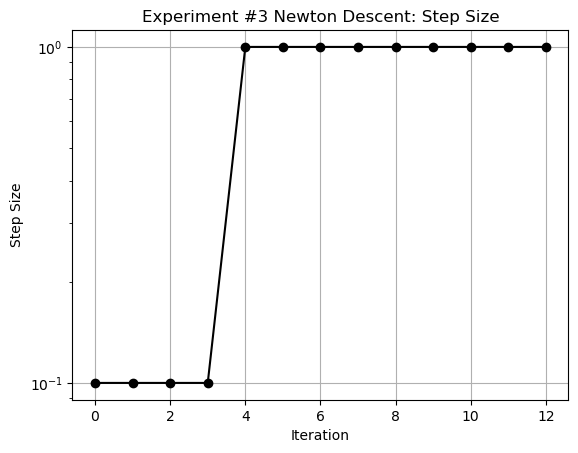

In [71]:
#Plot step sizes during Newton's Method
fig36 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #4: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.1$ 

In [72]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [73]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

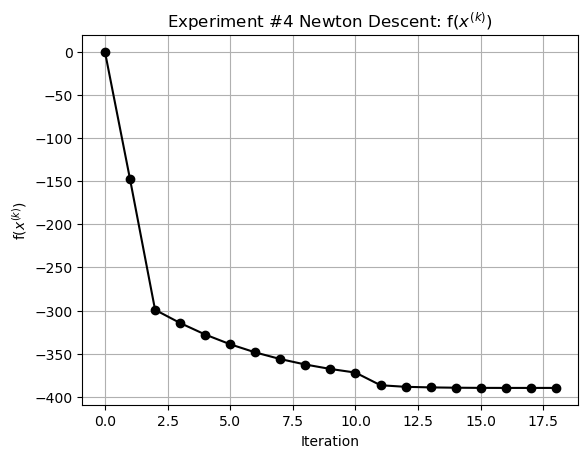

In [74]:
#Plot function values throughout Newton's Method
fig37 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #4 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

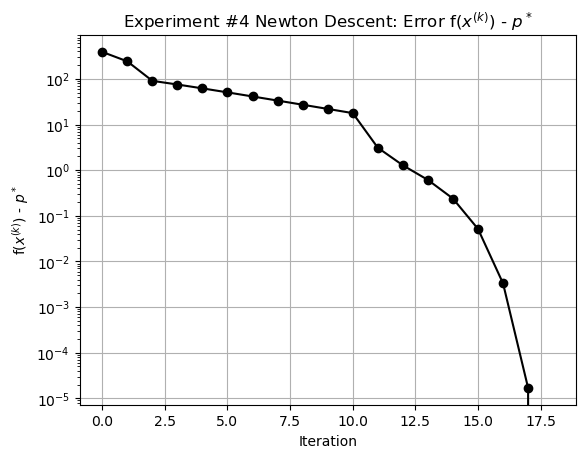

In [75]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
fig38 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #4 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [76]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1. , 1. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. ])

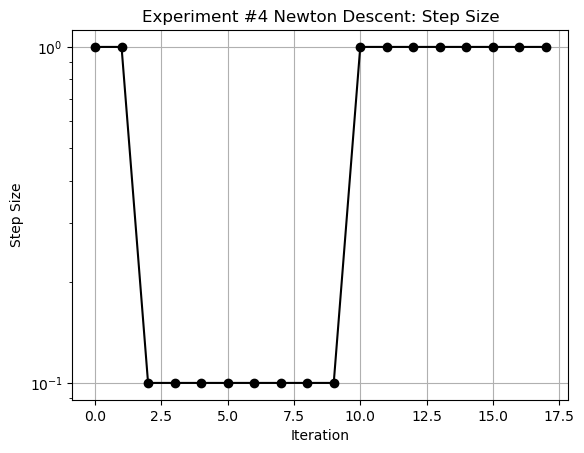

In [77]:
#Plot step sizes during Newton's Method
fig39 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #4 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #5: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.5$ 

In [78]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [79]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

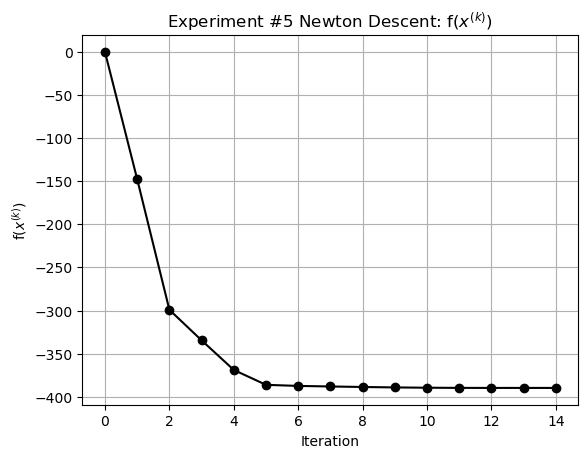

In [80]:
#Plot function values throughout Newton's Method
fig40 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #5 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

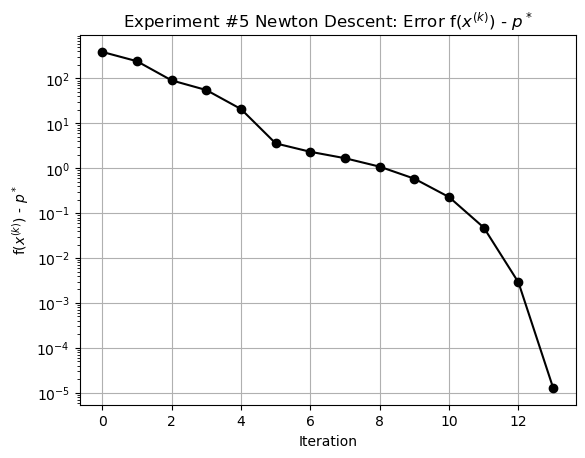

In [81]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]

fig41 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #5 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [82]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1.  , 1.  , 0.25, 0.5 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  ])

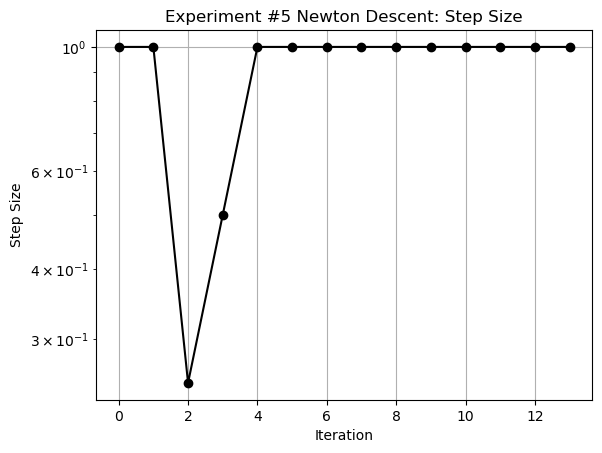

In [83]:
#Plot step sizes during Newton's Method
fig42 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #5 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #6: n = 200, m = 400, $\alpha = 0.15$, $\beta = 0.1$ 

In [84]:
#Global Variables
n = 200
m = 400
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [85]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

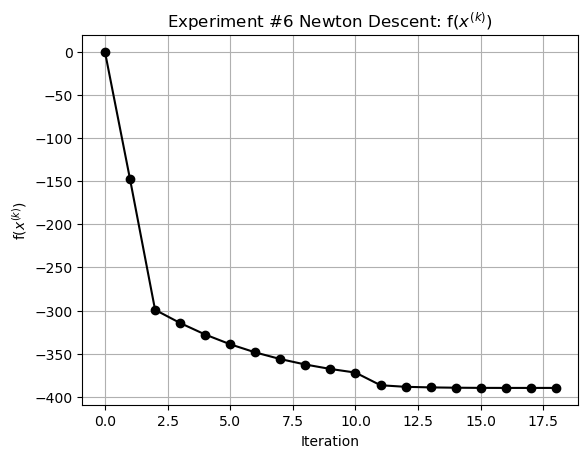

In [86]:
#Plot function values throughout Newton's Method
fig43 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #6 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

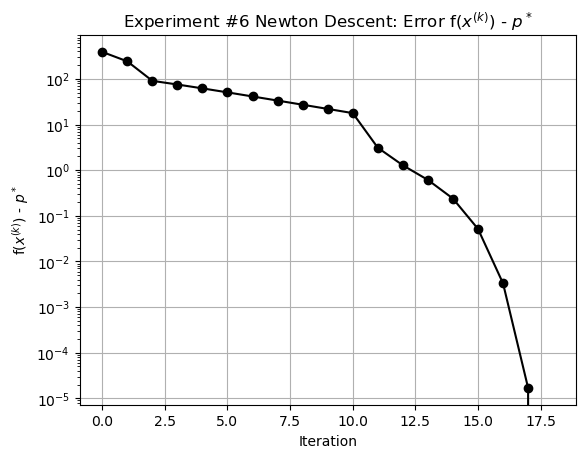

In [87]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
fig44 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #6 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [88]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1. , 1. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. ])

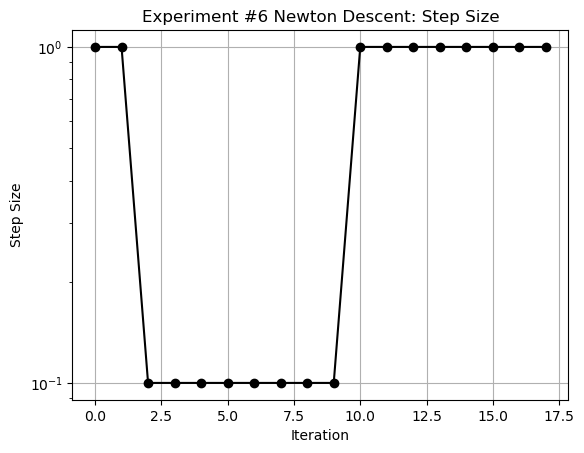

In [89]:
#Plot step sizes during Newton's Method
fig45 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #6 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #7: n = 50, m = 100, $\alpha = 0.01, \beta = 0.1$

In [90]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))


In [91]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

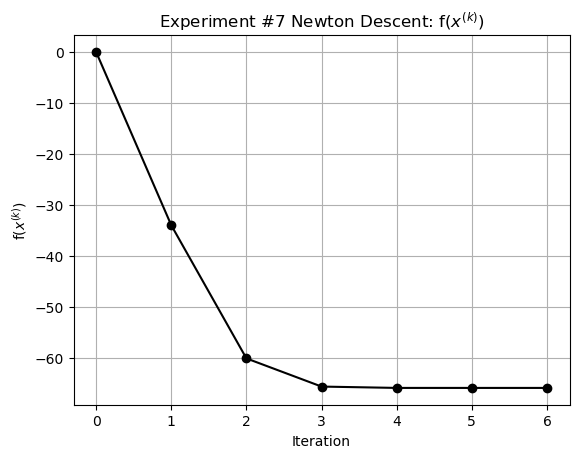

In [92]:
#Plot function values throughout Newton's Method
fig46 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #7 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


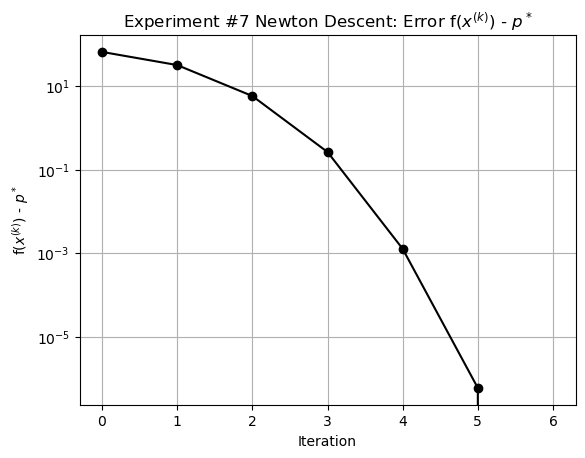

In [93]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
fig47 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #7 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [94]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1, 1, 1, 1, 1, 1])

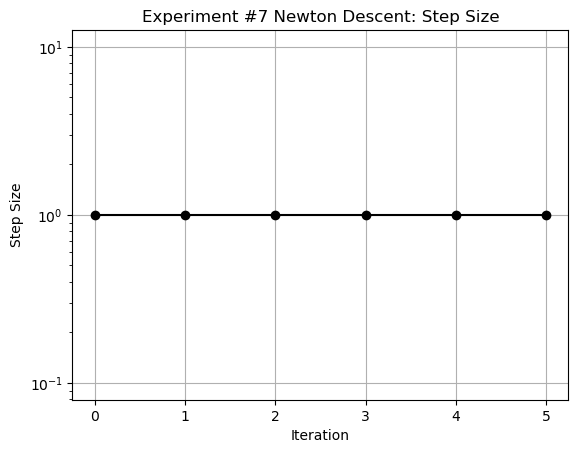

In [95]:
#Plot step sizes during Newton's Method
fig48 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #7 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #8: n = 50, m = 100, $\alpha = 0.01, \beta = 0.5$

In [96]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))


In [97]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)


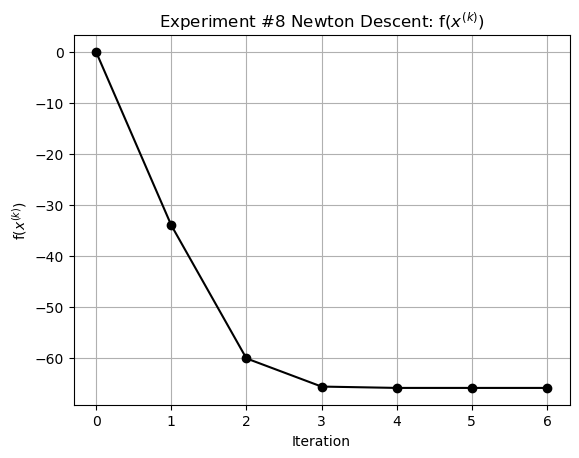

In [98]:
#Plot function values throughout Newton's Method
fig49 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #8 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


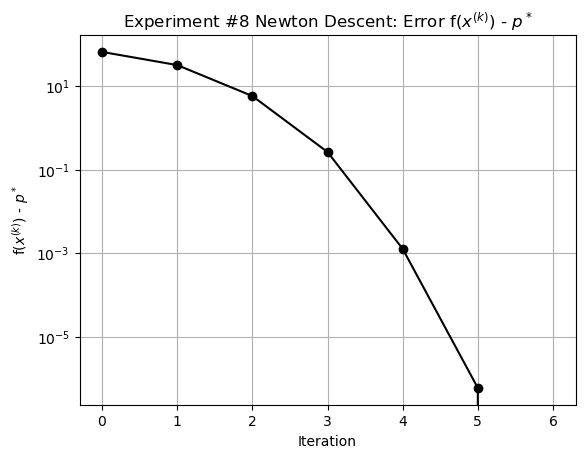

In [99]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
fig50 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #8 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [100]:
#Print step sizes during Newton's Method
newton_descent_step_sizes


array([1, 1, 1, 1, 1, 1])

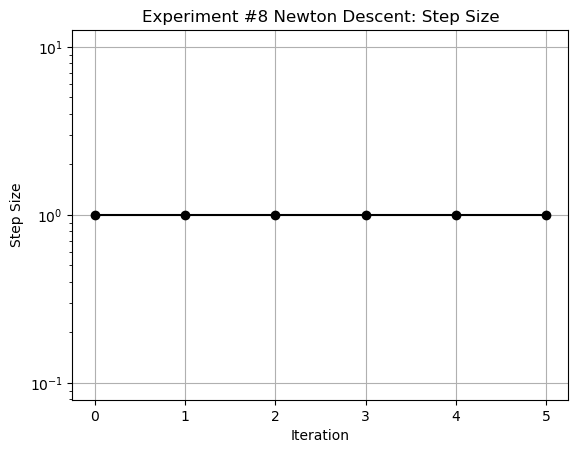

In [101]:
#Plot step sizes during Newton's Method
fig51 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #8 Newton Descent: Step Size')
plt.grid(True)
plt.show()


### Experiment #9: n = 50, m = 100, $\alpha = 0.15, \beta = 0.1$

In [102]:
#Global Variables
n = 50
m = 100
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))


In [103]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)


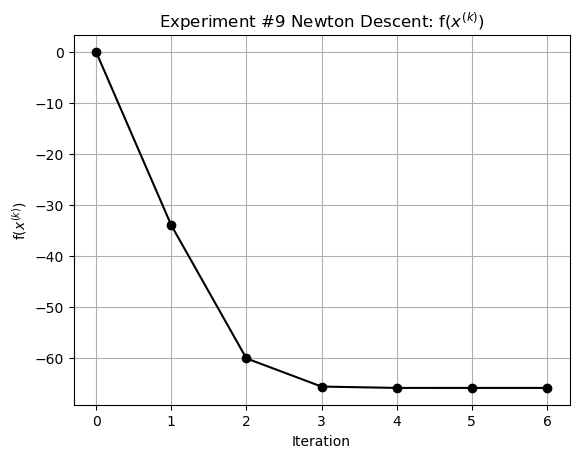

In [104]:
#Plot function values throughout Newton's Method
fig52 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #9 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


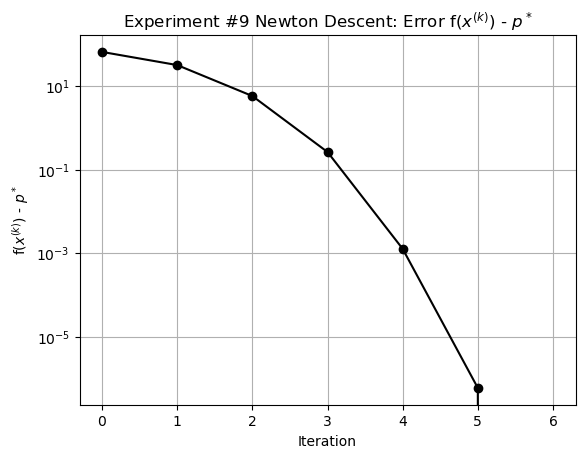

In [105]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
fig53 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #9 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [106]:
#Print step sizes during Newton's Method
newton_descent_step_sizes


array([1, 1, 1, 1, 1, 1])

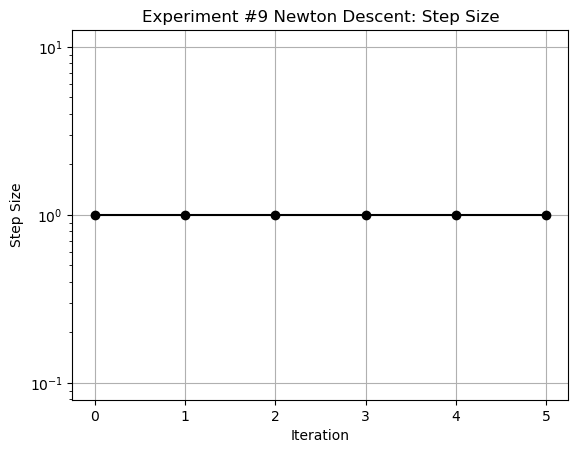

In [107]:
#Plot step sizes during Newton's Method
fig54 = plt.figure()  # Create a new figure
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #9 Newton Descent: Step Size')
plt.grid(True)
plt.show()


Observations:
- Backtracking Parameters $\alpha$ and $\beta$ do not affect the performance of Newton's Method that much when compared to Gradient Descent
- Performance is scaling well with problem size


## 9.31 (a)

### Experiment #1

In [108]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [109]:
#Run Gradient Descent
gradient_descent_eta = 1e-3
gradient_descent_max_iter = 80
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, gradient_descent_max_iter, gradient_descent_eta, alpha, beta)

In [110]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_step_sizes_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

In [111]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_step_sizes_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

In [112]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_step_sizes_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

In [113]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_step_sizes_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

In [114]:
#Run Newton's Method where Hessian is reused every 50 iteration
reused_newton_descent_iterates_N50, reused_newton_descent_function_values_N50, reused_newton_descent_step_sizes_N50 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 50)

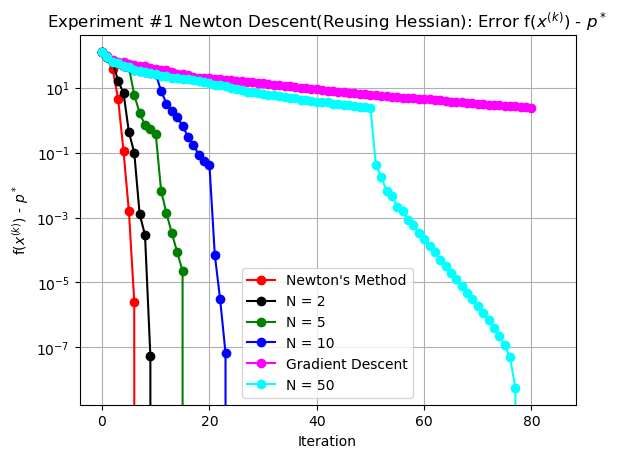

In [115]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10 and for Gradient Descent so that we can do comparisons
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed0
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed0
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed0
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed0
reused_newton_descent_gap_to_optimal_N50 = reused_newton_descent_function_values_N50 - p_star_seed0


# print(f"Gap to Optimal for N = 1: {reused_newton_descent_gap_to_optimal_N1}")
# print(f"Gap to Optimal for N = 2: {reused_newton_descent_gap_to_optimal_N2}")
# print(f"Gap to Optimal for N = 5: {reused_newton_descent_gap_to_optimal_N5}")
# print(f"Gap to Optimal for N = 10: {reused_newton_descent_gap_to_optimal_N10}")

fig55 = plt.figure()  # Create a new figure


line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')
line5, = plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='magenta', linestyle='-')
line6, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N50))), reused_newton_descent_gap_to_optimal_N50, marker='o', color='cyan', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4, line5, line6], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10', 'Gradient Descent', 'N = 50'])
plt.grid(True)
plt.show()

### Experiment #2

In [116]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [117]:
#Run Gradient Descent
gradient_descent_eta = 1e-3
gradient_descent_max_iter = 60
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, gradient_descent_max_iter, gradient_descent_eta, alpha, beta)

In [118]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_step_sizes_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

In [119]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_step_sizes_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

In [120]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_step_sizes_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

In [121]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_step_sizes_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

In [122]:
#Run Newton's Method where Hessian is reused every 50 iteration
reused_newton_descent_iterates_N50, reused_newton_descent_function_values_N50, reused_newton_descent_step_sizes_N50 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 50)

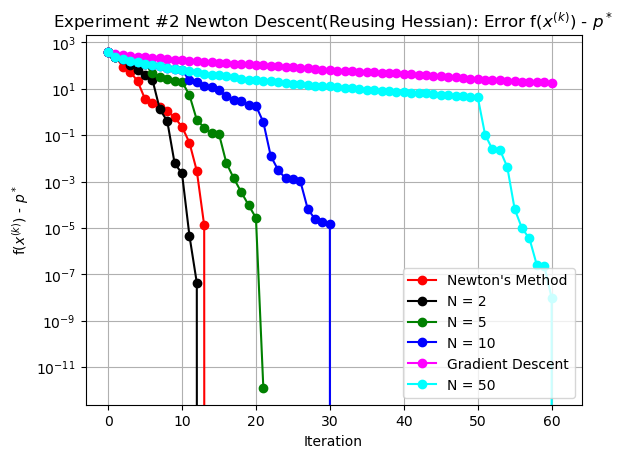

In [123]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10 and for Gradient Descent so we can compare
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed1
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed1
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed1
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed1
reused_newton_descent_gap_to_optimal_N50 = reused_newton_descent_function_values_N50 - p_star_seed1

fig56 = plt.figure()  # Create a new figure


line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')
line5, = plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='magenta', linestyle='-')
line6, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N50))), reused_newton_descent_gap_to_optimal_N50, marker='o', color='cyan', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4, line5, line6], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10', 'Gradient Descent', 'N = 50'])
plt.grid(True)
plt.show()

### Experiment #3

In [124]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [125]:
#Run Gradient Descent
gradient_descent_eta = 1e-3
gradient_descent_max_iter = 50
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, gradient_descent_max_iter, gradient_descent_eta, alpha, beta)

In [126]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_step_sizes_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

In [127]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_step_sizes_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

In [128]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_step_sizes_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

In [129]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_step_sizes_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

In [130]:
#Run Newton's Method where Hessian is reused every 50 iteration
reused_newton_descent_iterates_N50, reused_newton_descent_function_values_N50, reused_newton_descent_step_sizes_N50 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 50)

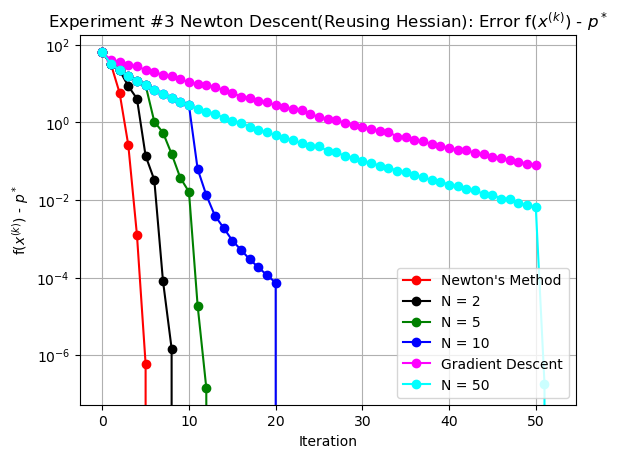

In [131]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10 and for Gradient Descent so we can compare
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed2
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed2
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed2
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed2
reused_newton_descent_gap_to_optimal_N50 = reused_newton_descent_function_values_N50 - p_star_seed2


# print(f"Gap to Optimal for N = 1: {reused_newton_descent_gap_to_optimal_N1}")
# print(f"Gap to Optimal for N = 2: {reused_newton_descent_gap_to_optimal_N2}")
# print(f"Gap to Optimal for N = 5: {reused_newton_descent_gap_to_optimal_N5}")
# print(f"Gap to Optimal for N = 10: {reused_newton_descent_gap_to_optimal_N10}")

fig57 = plt.figure()  # Create a new figure

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')
line5, = plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='magenta', linestyle='-')
line6, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N50))), reused_newton_descent_gap_to_optimal_N50, marker='o', color='cyan', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4, line5, line6], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10', 'Gradient Descent', 'N = 50'])
plt.grid(True)
plt.show()

Observations: 
- As N increases, the speed of convergence decreases
- As N increases, the convergence behavior begins to resemble the gradient descent convergence behavior more and more. 

## 9.31 (b)

### Experiment #1

In [132]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [133]:
#Run Gradient Descent
gradient_descent_eta = 1e-3
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, gradient_descent_eta, alpha, beta)

In [134]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

In [135]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_step_sizes = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

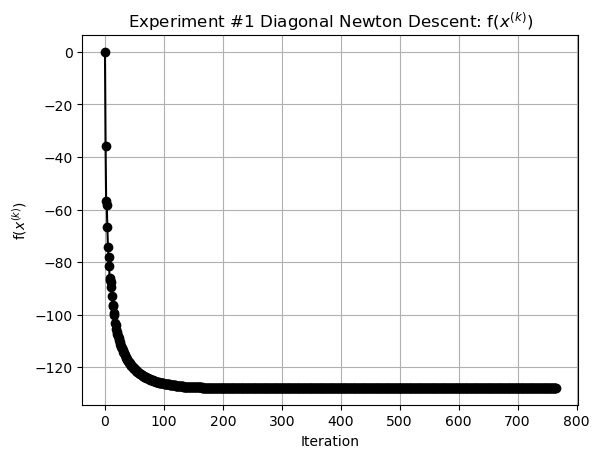

In [136]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
fig58 = plt.figure()  # Create a new figure
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

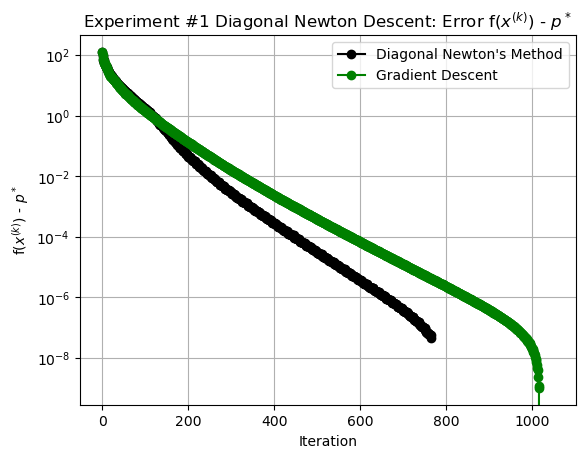

In [137]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal. 
#Also do this for regular newton's method and gradient descent for comparison
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed0
fig59 = plt.figure()  # Create a new figure

line1, = plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
# line2, = plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='red', linestyle='-')
line3, = plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='green', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line3], labels=['Diagonal Newton\'s Method', 'Gradient Descent'])
plt.grid(True)
plt.show()

In [138]:
#Just a print for debugging purposes
print(len(gradient_descent_gap_to_optimal))
print(len(diagonal_newton_descent_gap_to_optimal))

1050
766


### Experiment #2

In [139]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [140]:
#Run Gradient Descent
gradient_descent_eta = 1e-3
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, gradient_descent_eta, alpha, beta)

In [141]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

In [142]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_step_sizes = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

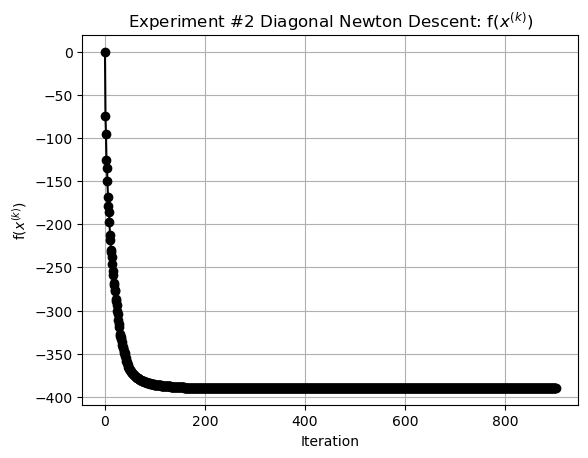

In [143]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
fig60 = plt.figure()  # Create a new figure
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

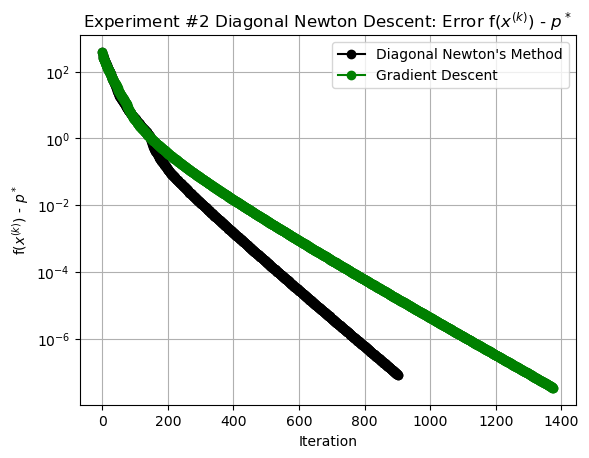

In [144]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal. 
#Also do this for regular newton's method and gradient descent for comparison
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed1

fig61 = plt.figure()  # Create a new figure
line1, = plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
# line2, = plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='red', linestyle='-')
line3, = plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='green', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line3], labels=['Diagonal Newton\'s Method', 'Gradient Descent'])
plt.grid(True)
plt.show()

### Experiment #3

In [145]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [146]:
#Run Gradient Descent
gradient_descent_eta = 1e-3
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, gradient_descent_eta, alpha, beta)

In [147]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

In [148]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_step_sizes = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

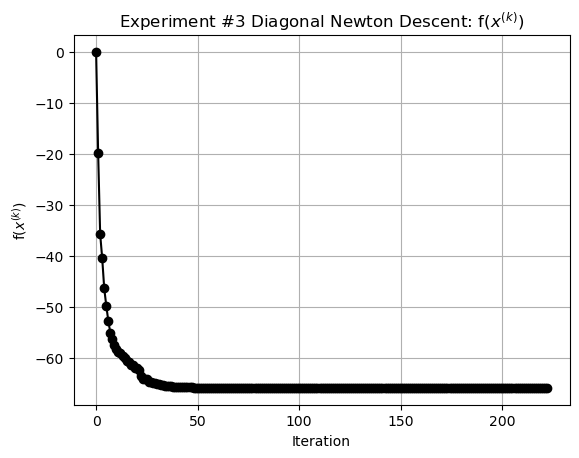

In [149]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
fig62 = plt.figure()  # Create a new figure
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

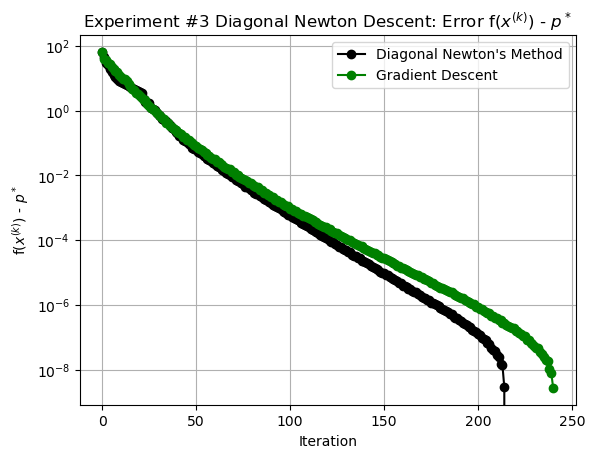

In [150]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal. 
#Also do this for regular newton's method and gradient descent for comparison
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed2
fig63 = plt.figure()  # Create a new figure
line1, = plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
# line2, = plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='red', linestyle='-')
line3, = plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='green', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line3], labels=['Diagonal Newton\'s Method', 'Gradient Descent'])
plt.grid(True)
plt.show()

In [151]:
#Just a print for debugging purposes
print(len(gradient_descent_gap_to_optimal))
print(len(diagonal_newton_descent_gap_to_optimal))

241
223


Observations: 
- When we are using the Diagonal Approximation of the Hessian, the convergence behavior strongly resembles that of the Gradient Descent Method

In [152]:
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt

pdf = matplotlib.backends.backend_pdf.PdfPages("Homework #5 Plots.pdf")

# Iterate through all the figures in the notebook
for i in range(1, 64):
    # Save each figure to the PDF
    pdf.savefig(globals()[f"fig{i}"])

# Close the PDF file
pdf.close()